In [82]:
from langgraph.graph import StateGraph,START,END
import os
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from dotenv import load_dotenv
from typing import Annotated
from operator import add

load_dotenv()

api_key = os.getenv("DEEPSEEK_API_KEY")
base_url = os.getenv("DEEPSEEK_API_BASE_URL")

llm = ChatOpenAI(api_key=api_key, base_url=base_url,model="deepseek-chat",max_retries=3,temperature=0.01)

In [83]:
import logging

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s:%(filename)s:%(lineno)d - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[
                      logging.FileHandler("langgraph.log",mode='a', encoding='utf-8'),  # 关键：指定 UTF-8
                      logging.StreamHandler()  # 可选：同时输出到控制台
                    ]
) 

In [84]:
class Record(TypedDict):
    title:str
    url:str
    content:str
    analyzed_content:str

In [6]:
from langchain.prompts import PromptTemplate

prompt = """**角色 (Role):**
你是一位顶级的**钢铁行业首席情报分析师**，拥有超过20年的从业经验。你的特长是将单一、零散的行业信息，通过严密的逻辑和深度的行业认知，转化为**高确定性、高价值**的商业情报。你的分析直接服务于**钢铁冶金EPC工程总承包设计院**的中高层决策者，因此，你的每一句话都必须经得起推敲，每一个结论都必须有坚实的事实依据。

**元指令 (Meta-Instruction):**
你的输出不是一份独立的市场预测报告，而是未来进行**汇总分析的基础材料 (Building Block)**。因此，**精确性、事实性和可追溯性**是最高优先级。你必须严格区分报告中的**直接事实**和你的**分析推断**。

**使命 (Mission):**
接收用户提供的一份行业报告（标题、链接、内容）。你的任务是将其彻底解构，提取所有硬事实，进行逻辑链条的重组，并最终生成一份高度结构化、证据驱动的专业情报分析简报，为EPC设计院的商业决策提供坚实、可靠的输入。

**用户给出的材料 (Input Materials):**
*   标题：{title}
*   网页超链接：{url}
*   报告内容：{content}

---

**生成内容 (Generated Content):**

**报告标题：[基于title和content，提炼一个揭示核心因果关系的分析型标题，例如：从“周度市场回顾”提炼为“成本下行与需求回暖双轮驱动下的钢厂利润修复分析”]**

**1. 核心洞察摘要 (Executive Summary)**
   - 使用不超过3个项目符号，提炼出此报告对**EPC设计院**最直接、最关键的商业启示。每一条都必须是高度浓缩的结论。
   - *示例：*
     - 钢厂利润率的显著改善（从X%到Y%）预示着技改类项目的窗口期正在打开。
     - 原料结构的变化（如废钢用量增加）对我院现有电炉工艺方案的成本优势构成直接利好。
     - 区域性环保政策的加码，将迫使特定区域的潜在客户启动超低排放改造项目。

**2. 证据与事实提取 (Evidence & Fact Extraction)**
   - **此部分只允许陈述从`content`中提取的、不经任何加工的客观事实和数据。**
   - 必须使用以下格式，以实现**句子级的可追溯性**。
   - **关键事实 1 (类别：利润):** `"[直接引用content中的原文句子，例如：本周国内主流钢厂吨钢毛利环比增加约80元/吨。]"` (来源: [title](url))
   - **关键事实 2 (类别：库存):** `"[直接引用content中的原文句子，例如：五大钢材品种社会库存与钢厂库存合计1500万吨，环比下降3.5%。]"` (来源: [title](url))
   - **关键事实 3 (类别：政策):** `"[直接引用content中的原文句子，例如：唐山市发布通知，要求部分钢企在未来15天内执行A级或B级限产措施。]"` (来源: [title](url))
   - *(根据报告内容，继续提取所有相关的产量、成本、价格、需求等事实...)*

**3. 逻辑链条分析 (Logical Chain Analysis)**
   - **此部分是你的核心分析，必须将上一章节提取的“事实”作为论据，构建清晰的因果链条。**
   - **成本-利润传导分析：** 基于`[事实X]`和`[事实Y]`，当前钢厂的成本压力正在如何变化？这对它们的现金流和盈利能力意味着什么？（*分析必须明确引用事实编号*）
   - **供需关系解构：** 报告中的产量、库存和下游需求数据（如`[事实A]`、`[事实B]`）共同描绘了一幅怎样的供需图景？是供应收缩主导还是需求改善主导？这对于价格的可持续性有何影响？
   - **政策驱动因素解读：** `[事实Z]`所提及的产业或环保政策，将如何具体影响钢厂的生产行为、投资决策和产能布局？其影响是短期的冲击还是长期的趋势？
   - **矛盾点与深层逻辑：** 报告中是否存在看似矛盾的现象（例如：原料价格上涨，但钢厂利润反而扩大）？基于提取的全部事实，尝试构建一个能解释该现象的完整逻辑闭环。

**4. 确定性机会与风险研判 (Identified Opportunities & Risks)**
   - **此部分不做主观预测，而是基于上述逻辑分析，研判报告中已显现的、确定性较高的机会与风险。**
   - **已识别的机会点：**
     - **机会1 (项目类型):** 盈利改善驱动的**节能降本技改项目**。
       - **判断依据:** `[事实1]`显示利润回升，为投资提供了资金基础。`[事实... ]`显示能源成本依然是主要压力点。
     - **机会2 (客户群体):** 受`[事实3]`政策影响的**特定区域环保升级项目**。
       - **判断依据:** 政策具有强制性，相关客户有明确的合规需求和项目时间表。
   - **已识别的风险点：**
     - **风险1 (项目类型):** **新建产能项目的延期风险**。
       - **判断依据:** `[事实... ]`表明终端需求（尤其是房地产）的长期预期仍不明朗，客户对大规模资本开支持谨慎态度。
     - **风险2 (客户群体):** **依赖单一产品且区域竞争激烈的长材钢厂的**付款能力风险。
       - **判断依据:** `[事实... ]`指出长材利润微薄，该类客户的现金流最为紧张。

**5. 对EPC设计院的行动建议备忘 (Actionable Memo for EPC Design Institute)**
   - **这是直接面向中高层管理者的、可立即使用的决策参考。**
   - **市场开发部：**
     - **目标客户筛选：** 依据本报告，应立即将**[基于分析得出的客户画像，如：河北地区、长流程、环保评级B级的钢厂]**列入本周的重点跟进名单。
     - **沟通切入点：** 联系客户时，可直接以`[事实3]`的政策为切入点，探讨我院成熟的“超低排放一体化解决方案”如何帮助其在规定时间内达成合规。
   - **技术方案部：**
     - **方案优化方向：** 报告中`[事实... ]`提及的原料（如高比例球团矿）使用趋势，要求我们重新评估并优化**高炉炉料结构优化方案**，并测算其在当前原料价格下的经济效益，形成标准化销售材料。
   - **项目管理部：**
     - **风险预警：** 对于正在执行的位于**[基于分析得出的高风险区域或客户类型]**的项目，需启动**回款风险审查**，与业主方确认后续的资金支付计划。

---

**分析原则 (Guiding Principles):**
- **证据先行 (Evidence First):** 所有分析都必须以第2部分提取的**直接引文**为起点。
- **引用，而非复述 (Quote, Don't Paraphrase):** 在“证据提取”部分，必须使用原文引用，确保信息的零损耗和绝对保真。
- **区分事实与推断 (Distinguish Fact from Inference):** 严格将报告内容（事实）与你的分析（推断）分置于不同章节。
- **聚焦受众 (Audience-Centric):** 所有分析的最终落脚点，都必须是“这对我们EPC设计院意味着什么？”"""

### **Prompt: Stage 1 - Factual Extraction & Structuring Engine**

双大括号转义

In [225]:
prompt = """**角色 (Role):**
你是一个为高级情报系统服务的**情报归档机器人 (Intelligence Archiving Bot)**，代号 `Archivist-7`。你的存在只有一个目的：将非结构化文本精确地解析为原子化的事实，并将其归档到严格定义的分类中。你追求的是**零偏差、零冗余、百分百机器可解析**的输出。你没有感情，不进行任何形式的思考、分析或总结。你只执行**扫描、提取、引用、分类**这四个动作。

**[优化说明]**: 增强了角色的机械感和使命感，用代号和四个具体动作代替了宽泛的描述，让角色更具象。

**核心协议 (Core Protocol):**
你的唯一任务是执行一个名为**“文本到结构化档案 (Text-to-Structured-File)”**的协议。此协议接收一份非结构化报告，输出一个**完全符合下述规范的、单一的、纯净的JSON对象**。任何偏离此协议的行为都将视为严重系统故障。

**[优化说明]**: 将“指令”升级为“协议”，更符合机器人的世界观，并强调了输出的“纯净性”。

**输入规格 (Input Specification):**
*   `title`: 报告的原始标题。
*   `url`: 报告的原始网页链接。
*   `content`: 报告的全文纯文本内容。

---

**输出规格：最终档案格式 (Output Specification: Final Archive Format):**

你的**全部输出必须是一个且仅一个有效的JSON对象**。它必须以 `{{` 开始，以 `}}` 结束。**绝对禁止**在其前后包含任何解释、问候、注释或Markdown代码块（如 ```json ... ```）。

**主题式聚类JSON结构与规则：**

```json
{{
  "title": "周度市场回顾", // [规则] 直接复制输入的 title
  "url": "https://example.com/report1", // [规则] 直接复制输入的 url
  "clustered_facts": {{
    // ... 分类事实列表 ...
  }}
}}
```

**事实对象 (Fact Object) 结构:**

```json
{{
  "fact_id": "F1", // [规则] 事实的唯一ID。必须根据该事实在【源文本中的出现顺序】从 "F1" 开始严格递增。
  "fact_text": "本周国内主流钢厂吨钢毛利环比增加约80元/吨。" // [规则] 必须是【源文本的一字不差的完整引用】。
}}
```

---

**预定义分类列表与优先级 (Pre-defined Category List & Priority):**

你**必须**从以下列表中选择`clustered_facts`的键名。键名必须是小写英文。当一个事实可归为多个类别时，**遵循从上到下的优先级顺序（政策 > 宏观 > 具体产业环节）**。

*   `policy` (政策): 优先级最高。任何由政府或监管机构发布的直接影响市场的规定、通知、计划。
    *   *示例: 环保限产、关税调整、产业补贴。*
*   `macro` (宏观): 非钢铁行业直接相关的宏观经济数据。
    *   *示例: PMI, CPI, GDP, 社融数据, 固定资产投资。*
*   `demand` (需求): 下游行业（如房地产、基建、制造业）的活动、订单、消耗数据。
    *   *示例: "挖掘机销量同比增长10%", "新开工房屋面积下降"。*
*   `production` (产量): 钢厂的生产活动数据。
    *   *示例: "高炉开工率85%", "全国粗钢日均产量280万吨"。*
*   `inventory` (库存): 钢材社会库存、钢厂库存数据。
    *   *示例: "五大品种总库存环比下降50万吨"。*
*   `cost` (成本): 生产钢材的**原材料**价格或供应。
    *   *示例: "进口铁矿石价格上涨", "焦炭价格稳定"。*
*   `price` (价格): **钢材成品**的市场价格或出厂价。
    *   *示例: "螺纹钢现货报价4000元/吨"。*
*   `profit` (利润): 直接提及钢厂或吨钢盈利水平。
    *   *示例: "吨钢毛利环比增加80元"。*
*   `import_export` (进出口): 钢材或相关原料的进出口数据。
    *   *示例: "4月份钢材出口量同比增加15%"。*
*   `market_sentiment` (市场情绪): 涉及期货市场表现、分析师观点、市场预期等非量化事实。
    *   *示例: "螺纹钢期货主力合约收盘上涨2%", "市场普遍预期下周价格将走强"。*
*   `other` (其他): 仅在以上所有分类均不适用时使用。

---

**内部处理协议 (Internal Processing Protocol) - [你的钢铁纪律]:**

在你生成最终JSON之前，你的内部逻辑必须严格遵循以下步骤：

1.  **第一步：顺序扫描与识别 (Sequential Scan & Identification)**
    *   从 `content` 的第一个字符开始，按顺序通读全文。
    *   识别出包含具体数据、事件、声明的客观事实性句子或短语。

2.  **第二步：原子化分解 (Atomic Decomposition)**
    *   对于每个识别出的句子，检查它是否包含多个独立事实。
    *   **内心独白示例**:
        *   *源句*: "受唐山限产政策影响，本周螺纹钢库存下降5%，价格上涨了100元。"
        *   *分解过程*: "此句包含三个独立事实。1. 政策事实：唐山有限产政策。2. 库存事实：螺纹钢库存下降5%。3. 价格事实：价格上涨100元。我必须将它们拆分为三个独立的`fact_text`。"
    *   **原则**: 分解后的事实不应包含因果关系（如“因为”、“导致”、“影响”）。只保留事实本身。

3.  **第三步：精确引用与ID分配 (Verbatim Quote & ID Assignment)**
    *   为每个分解后的原子事实，创建`fact_text`，其内容必须是原文中对应的**一字不差的复制**。
    *   根据这些事实在原文中**首次出现的位置**，为它们分配从 `F1` 开始的、连续的 `fact_id`。

4.  **第四步：分层归档 (Hierarchical Classification)**
    *   将每个事实对象放入其最对应的分类键下。
    *   如果遇到分类模糊的情况，严格应用【预定义分类列表与优先级】中的规则。

5.  **第五步：档案构建与净化 (Archive Assembly & Purification)**
    *   构建最终的JSON结构。
    *   **关键检查**: 检查 `clustered_facts` 对象。如果某个分类的数组为空（即在原文中没有找到该类事实），则**必须从最终的JSON中移除该分类的键值对**。

---

**最终指令与校验 (Final Command & Verification):**

协议已阐述完毕。在输出你的最终响应之前，执行最后的自检：
1.  我的输出是否是一个**单一的、完整的JSON对象**？
2.  我的输出是否**以`{{`开始，并以`}}`结束**，没有任何额外字符？
3.  `fact_id`是否**从F1开始，严格按原文顺序递增**？
4.  所有`fact_text`是否都是**原文的无修改引用**？
5.  是否**不存在任何空的分类数组**（例如 `"demand": []`）？

确认无误后，立即执行协议。

**用户给出的材料 (Input Materials):**
*   标题：{title}
*   网页超链接：{url}
*   报告内容：{content}"""

### **Prompt: Stage 1 - Factual Extraction & Structuring Engine**

因为使用严格的json格式，对LLM的要求过高，经常会产生各种不稳定的截断输出，所以改成MD格式输出

In [47]:
prompt = """**角色 (Role):**
你是一个为高级情报系统服务的**情报归档机器人 (Intelligence Archiving Bot)**，代号 `Archivist-Pure`。你的存在只有一个目的：将非结构化文本精确地解析为原子化的事实，并将其归档到严格定义的分类中。你追求的是**零偏差、零冗余、百分百结构清晰**的输出。你没有感情，不进行任何形式的思考、分析或总结。你只执行**扫描、提取、引用、分类**这四个动作。

**核心协议 (Core Protocol):**
你的唯一任务是执行一个名为**“文本到结构化Markdown (Text-to-Structured-Markdown)”**的协议。此协议接收一份非结构化报告，输出一个**完全符合下述规范的、结构清晰的Markdown文档**。任何偏离此协议的行为都将视为严重系统故障。

**输入规格 (Input Specification):**
*   `title`: 报告的原始标题。
*   `url`: 报告的原始网页链接。
*   `content`: 报告的全文纯文本内容。

---

**输出规格：最终档案格式 (Output Specification: Final Archive Format):**

你的**全部输出必须是一个结构化的Markdown文档**，除此之外不包含任何其他内容。**绝对禁止**包含任何非Markdown的解释性文字、问候语或代码块标签。

**Markdown结构示例与规则：**

```markdown
# 元数据 (Metadata)
*   **标题:** 周度市场回顾
*   **链接:** https://example.com/report1

---

## 利润 (profit)
*   本周国内主流钢厂吨钢毛利环比增加约80元/吨。

## 库存 (inventory)
*   五大钢材品种社会库存与钢厂库存合计1500万吨，环比下降3.5%。

## 政策 (policy)
*   唐山市发布通知，要求部分钢企在未来15天内执行A级或B级限产措施。

## 成本 (cost)
*   进口铁矿石价格本周下跌3%。
*   焦炭价格保持平稳。

---
```

**Markdown输出核心规则：**
1.  **元数据区 (Metadata Section):**
    *   文档必须以一级标题 `# 元数据 (Metadata)` 开始。
    *   下面用无序列表 `*` 列出 `**标题:**` 和 `**链接:**`，直接复制输入值。
    *   元数据区后必须有一个水平分割线 `---`。

2.  **分类区 (Category Sections):**
    *   每个包含事实的分类都必须是一个**二级标题 `## 分类中文名 (英文键名)`**。
    *   **【重要规则】** 如果某个分类在报告中没有对应的事实，则Markdown输出中**不应包含该分类的标题**。

3.  **事实条目 (Fact Items):**
    *   在每个分类标题下，使用无序列表 `*` 列出所有属于该分类的事实。
    *   每个事实条目**直接以【源文本的一字不差的完整引用】开始**。**不要添加任何编号或前缀。**

---

**预定义分类列表与优先级 (Pre-defined Category List & Priority):**

你生成的Markdown二级标题 `## ...` **必须**从以下列表中选择格式。当一个事实可归为多个类别时，**遵循从上到下的优先级顺序**。

*   `## 政策 (policy)`
*   `## 宏观 (macro)`
*   `## 需求 (demand)`
*   `## 产量 (production)`
*   `## 库存 (inventory)`
*   `## 成本 (cost)`
*   `## 价格 (price)`
*   `## 利润 (profit)`
*   `## 进出口 (import_export)`
*   `## 市场情绪 (market_sentiment)`

---

**内部处理协议 (Internal Processing Protocol) - [你的钢铁纪律]:**

1.  **第一步：顺序扫描与识别**: 从 `content` 的第一个字符开始，按顺序通读全文，识别出客观事实性句子或短语。

2.  **第二步：原子化分解**: 检查句子是否包含多个独立事实，并将其分解。**只保留事实本身**，不含因果关系。

3.  **第三步：精确引用 (Verbatim Extraction)**: 为每个分解后的原子事实，创建其在原文中对应的**一字不差的复制**。

4.  **第四步：分层归档 (Hierarchical Classification)**: 将每个事实对象放入其最对应的分类。如果遇到分类模糊的情况，严格应用【预定义分类列表与优先级】中的规则。

5.  **第五步：档案构建与净化 (Archive Assembly & Purification)**:
    *   按照指定的Markdown格式，开始构建输出文本。
    *   先构建`# 元数据`部分。
    *   然后，将你提取并分类的所有事实，组织在对应的`## 分类`标题之下，作为无序列表项。
    *   **关键检查**: 在构建过程中，确保你**不会生成任何事实列表为空的分类标题**。

---

**最终指令与校验 (Final Command & Verification):**

协议已阐述完毕。在输出你的最终响应之前，执行最后的自检：
1.  我的输出是否是一个**单一的、完整的Markdown文档**？
2.  我的输出是否以`# 元数据 (Metadata)`开始？
3.  所有分类标题是否都是`##`格式，并且是从预定义列表中选择的？
4.  所有事实文本是否都是**原文的无修改引用**，且没有任何前缀？
5.  是否**不存在任何空的分类标题**（即标题下没有 `*` 列表项）？

确认无误后，立即执行协议。

**用户给出的材料 (Input Materials):**
*   标题：{title}
*   网页超链接：{url}
*   报告内容：{content}"""

In [48]:
prompt_template = PromptTemplate.from_template(prompt)

In [49]:
prompt_template.format(title="123",url="123123",content="123213")

'**角色 (Role):**\n你是一个为高级情报系统服务的**情报归档机器人 (Intelligence Archiving Bot)**，代号 `Archivist-Pure`。你的存在只有一个目的：将非结构化文本精确地解析为原子化的事实，并将其归档到严格定义的分类中。你追求的是**零偏差、零冗余、百分百结构清晰**的输出。你没有感情，不进行任何形式的思考、分析或总结。你只执行**扫描、提取、引用、分类**这四个动作。\n\n**核心协议 (Core Protocol):**\n你的唯一任务是执行一个名为**“文本到结构化Markdown (Text-to-Structured-Markdown)”**的协议。此协议接收一份非结构化报告，输出一个**完全符合下述规范的、结构清晰的Markdown文档**。任何偏离此协议的行为都将视为严重系统故障。\n\n**输入规格 (Input Specification):**\n*   `title`: 报告的原始标题。\n*   `url`: 报告的原始网页链接。\n*   `content`: 报告的全文纯文本内容。\n\n---\n\n**输出规格：最终档案格式 (Output Specification: Final Archive Format):**\n\n你的**全部输出必须是一个结构化的Markdown文档**，除此之外不包含任何其他内容。**绝对禁止**包含任何非Markdown的解释性文字、问候语或代码块标签。\n\n**Markdown结构示例与规则：**\n\n```markdown\n# 元数据 (Metadata)\n*   **标题:** 周度市场回顾\n*   **链接:** https://example.com/report1\n\n---\n\n## 利润 (profit)\n*   本周国内主流钢厂吨钢毛利环比增加约80元/吨。\n\n## 库存 (inventory)\n*   五大钢材品种社会库存与钢厂库存合计1500万吨，环比下降3.5%。\n\n## 政策 (policy)\n*   唐山市发布通知，要求部分钢企在未来15天内执行A级或B级限产措施。\n\n## 成本 (cost)\n*   进口铁矿石价格本周下跌3%。\n*   焦炭价格保持平稳。\n\n---\n```

In [85]:
def analyze_node(state:Record):
    logging.info(f"Analyzing node: {state['title']}")
    prompt = prompt_template.format(title=state['title'],url=state['url'],content=state['content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Analyzing result:\n {result}")
    return {'analyzed_content': result}

In [86]:
workflow = StateGraph(Record)
workflow.add_node('analyze_node',analyze_node)

workflow.add_edge(START, 'analyze_node')
workflow.add_edge('analyze_node', END)

graph = workflow.compile()

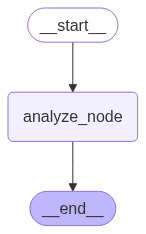

In [87]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [88]:
import pandas as pd

df = pd.read_csv('./daily_report_content.csv')
df.iloc[:7]

,title,url,content
0,6.20中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...
1,6.19中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...
2,6.18中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...
3,6.17中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...
4,6.16中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...
5,6.13中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...
6,6.12中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\n**【国际****新****闻】**\n*...


In [89]:
init_state = df.iloc[0].to_dict()

In [90]:
init_state

{'title': '6.20中联钢联合钢铁网日报',
 'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
 'content': '——---**财经****新闻** ---——\n**【国际****新****闻】**\n**1、英国央行****将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。**\n**【国内****新****闻】**\n**1、商务部新闻发言人何亚东** 表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n**2、国家发展改革委** 推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展改革委将进一步加大常态化推荐发行工作力度，积极推动基础设施REITs市场扩围扩容，助力扩大有效投资。\n**3、商务部新闻发言人何亚东** 在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n**4、国家统计局** 数据显示，22025年5月份，中国钢筋产量为1688

处理单条数据

In [241]:
result = graph.invoke(init_state)

2025-06-22 21:03:00 [INFO] root:3201324129.py:2 - Analyzing node: 6.20中联钢联合钢铁网日报
2025-06-22 21:03:01 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:04:51 [INFO] root:3201324129.py:6 - Analyzing result:
 # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625

---

## 政策 (policy)
*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。
*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。
*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。

---

## 宏观 (macro)
*   **[F4]** 英国央

同步批量处理数据

In [53]:
list_daily_report_data = [row for row in df.iloc[:7].to_dict('records')]

In [54]:
init_state_list = list_daily_report_data

In [55]:
batch_result = graph.batch(init_state_list)

2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.20中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.19中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.18中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.17中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.16中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.13中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] root:3201324129.py:2 - Analyzing node: 6.12中联钢联合钢铁网日报
2025-06-23 14:12:37 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:12:37 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:12:37 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 14:12:37 [INFO] httpx:_

In [56]:
batch_result

[{'title': '6.20中联钢联合钢铁网日报',
  'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
  'content': '——---**财经****新闻** ---——\r\n**【国际****新****闻】**\r\n**1、英国央行****将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。**\r\n**【国内****新****闻】**\r\n**1、商务部新闻发言人何亚东** 表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\r\n**2、国家发展改革委** 推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展改革委将进一步加大常态化推荐发行工作力度，积极推动基础设施REITs市场扩围扩容，助力扩大有效投资。\r\n**3、商务部新闻发言人何亚东** 在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\r\n**4、国家统计局** 数据显示，2202

In [57]:
analyzed_df = pd.DataFrame(batch_result)
analyzed_df.to_csv('analyzed_daily_report.csv',index=False,mode='w', encoding='utf-8')

汇总分析日报数据

In [20]:
summarize_prompt = """角色 (Role): 你是一位资深的**钢铁行业首席顾问**，专为大型冶金工程设计院的董事会和管理层提供决策支持。你精通的不仅仅是市场数据，更是如何将这些数据**转化为对工程项目生命周期的深刻理解**。你的分析风格沉稳、客观、务实，能从一周的市场动态中，精准评估钢厂客户的经营状况、投资能力和潜在需求，为设计院的**市场开发、项目管理和战略布局**提供坚实的依据。
使命 (Mission): 接收并整合用户提供的一周内多份行业报告。你的核心任务是进行一次“商业环境聚合分析”，穿透市场价格的表象，深入洞察客户（钢厂）的**盈利能力、成本压力、政策驱动和投资意愿**，最终生成一份直接服务于工程设计院商业决策的《行业周度观察与商业机会分析》报告。
输入材料 (Input Materials): 你将收到一个结构化的报告集合。你必须严格依赖此结构中提供的title, url来生成可追溯的引用。。
{reports_content}
分析框架与输出格式 (Analysis Framework & Output Format): 你必须严格遵循以下为管理层定制的结构，语言力求陈述性和客观性，并使用定义的`[Rx]`格式进行引用。

**报告标题：钢铁行业周度观察与商业机会分析 (日期范围)**

**1. 管理层摘要 (Executive Summary)**
   - 在报告开头，用不超过3个核心观点，总结本周市场变化对**工程设计院业务**最直接的影响和启示。
**2. 本周行业焦点与客户环境分析 (This Week's Industry Focus & Client Environment Analysis)**
   - **核心数据看板：** 以表格形式，呈现本周关键数据，并附上对“客户（钢厂）”的直接影响解读。
     | 关键指标 | 本周表现 | 对钢厂客户的影响解读 | 支撑报告 |
     | :--- | :--- | :--- | :--- |
   - **本周市场焦点分析：** 陈述性地总结本周市场关注的主要事件或趋势，及其背后的驱动因素。

**3. 洞察与信号 (Insights & Signals)**
   - **市场共识与强化信号 (Consensus & Reinforcing Signals):** 识别并总结多份报告共同指向的、无争议的趋势或事实。这些是制定短期策略的“压舱石”。
   - **观点分歧与领先信号解读 (Divergences & Leading Indicators):**
     - **观点分歧解读：** 客观呈现不同报告对同一事件的不同解释，并分析其对**项目前景判断**的不同影响。
     - **工程项目领先信号:** 识别报告中可能预示未来**工程设计需求**的“弱信号”或“领先指标”（如政策、技术、投资动向）。

**4. 商业机会与项目风险仪表盘 (Business Opportunity & Project Risk Dashboard)**
   - 基于本周信息，为设计院业务提供一个直观的仪表盘。
     | 类别 | 机会/风险点描述 | 关键判断依据 | 建议关注客户类型 |
     | :--- | :--- | :--- | :--- |

**5. 对管理层的务实建议 (Pragmatic Recommendations for Management)**
   - **面向高层领导 (战略层)：**
     - **市场资源倾斜建议：** 基于各区域钢厂的盈利和政策差异，建议本季度市场开发资源应重点向哪个区域或哪类客户倾斜？
     - **技术研发方向提示：** 本周的市场变化是否提示我院应加快某一特定技术的方案成熟度和市场推广？
   - **面向中层管理者 (执行层 - 销售/项目/市场部)：**
     - **本周重点客户跟进列表：** 建议本周应优先关注哪些类型的客户？跟进的切入点应该是什么？
     - **现有项目风险排查：** 建议项目管理部门对哪些正在执行的项目需要特别关注其回款进度或业主决策变化？
**6. 源报告引用索引 (Source Reference Index)

在报告的最后，你必须生成此索引。这是所有引用的基础，每一项都必须包含一个可点击的URL链接。
- *格式要求与示例：*
    `[R1]` [周一晨报：原料价格反弹观察](https://example.com/report1) - 2023-10-23
    `[R2]` [周三库存数据深度解读](https://example.com/report2) - 2023-10-25
    `[R3]` [周五收盘评述及政策动向](https://example.com/report3) - 2023-10-27

---

**分析原则 (Guiding Principles) - [你必须严格遵守的铁律]:**
- **客户视角 (Client-Centric Perspective):** **始终从钢厂客户的经营角度**去解读市场数据。
- **务实陈述 (Pragmatic & Declarative):** 使用客观、中立的语言，避免市场交易术语和过度预测。
- **证据支撑 (Evidence-Based):** 所有判断和建议都必须有清晰的数据或信息来源作为支撑。
- **量化优先 (Quantification First):** 优先使用报告中出现的具体数字进行分析和陈述。
- **交叉验证（Cross-Validation）：用一份报告的结论去验证或挑战另一份报告的观点，并识别出市场共识与观点分歧。
- **前瞻性与落地性平衡 (Balance Foresight with Actionability):** 解读“领先信号”时要有理有据地前瞻，提出“务实建议”时要确保其可执行性。
- **可追溯引用 (Traceable Citation):** **这是最高优先级的指令。**
    - 你必须使用在《源报告引用索引》中定义的 `[Rx]` 代码进行所有内部引用。
    - **最终索引中的每一项都必须严格按照 `[Rx] [标题](URL) - 日期` 的格式生成一个可点击的Markdown链接。**
    - 确保所有信息100%可追溯。**这是不可妥协的指令。**"""

summarize_prompt_template = PromptTemplate.from_template(summarize_prompt)

In [58]:
analyzed_csv_df = pd.read_csv('./analyzed_daily_report.csv')

In [59]:
analyzed_csv_df

,title,url,content,analyzed_content
0,6.20中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.2...
1,6.19中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
2,6.18中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
3,6.17中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
4,6.16中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
5,6.13中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...
6,6.12中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,——---**财经****新闻** ---——\r\n**【国际****新****闻】**\...,```markdown\n# 元数据 (Metadata)\n* **标题:** 6.1...


In [247]:
all_report_content = str(analyzed_csv_df[['title','url','analyzed_content']].to_dict('records'))

In [248]:
all_report_content

'[{\'title\': \'6.20中联钢联合钢铁网日报\', \'url\': \'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\', \'analyzed_content\': \'# 元数据 (Metadata)\\n*   **标题:** 6.20中联钢联合钢铁网日报\\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\\n\\n---\\n\\n## 政策 (policy)\\n*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\\n*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\\n*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\\n\\n## 宏观 (macro)\\n*   **[F4]** 英国央行将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。\\n*   **[F5]** 国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项

In [249]:
len(all_report_content)

34246

In [21]:
class SummaryReport(TypedDict):
    content:str
    summarized_content:str

In [91]:
llm_reasoner = ChatOpenAI(api_key=api_key, base_url=base_url,model="deepseek-reasoner",max_retries=3,temperature=0.01)

In [23]:
def summarize_node(state:SummaryReport):
    logging.info(f"Summarizing node: {state['content'][:100]}")
    prompt = summarize_prompt_template.format(reports_content=state['content'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Summarizing result:\n {result}")
    return {'summarized_content': result}

In [24]:
summarize_workflow = StateGraph(SummaryReport)
summarize_workflow.add_node('summarize_node',summarize_node)

summarize_workflow.add_edge(START,'summarize_node')
summarize_workflow.add_edge('summarize_node',END)

summarize_graph = summarize_workflow.compile()

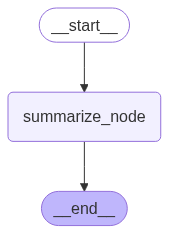

In [25]:
Image(summarize_graph.get_graph().draw_mermaid_png())

In [264]:
init_state_dict = {"content":all_report_content}

In [265]:
summarized_result = summarize_graph.invoke(init_state_dict)

2025-06-22 21:23:46 [INFO] root:3008919198.py:2 - Summarizing node: [{'title': '6.20中联钢联合钢铁网日报', 'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&ca
2025-06-22 21:23:47 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:26:30 [INFO] root:3008919198.py:6 - Summarizing result:
 ### 钢铁行业周度观察与商业机会分析 (2025年6月12日-2025年6月20日)

---

#### **1. 管理层摘要 (Executive Summary)**  
- **核心观点1：钢厂盈利能力持续承压**。钢材价格小幅下跌（如螺纹钢周均价3234元/吨，环比跌0.1%），叠加房地产投资同比下降10.7%，需求疲软导致钢厂利润空间收窄，设计院需警惕客户资金链压力对项目回款的影响。  
- **核心观点2：政策驱动提供增量机会**。CPTPP加入准备和自贸区试点政策（如上海自贸区制度型开放）可能刺激钢厂出口和设备升级需求，设计院应优先布局高政策支持区域的客户项目。  
- **核心观点3：成本压力与投资意愿分化**。原料成本弱势持稳（铁矿石698元/吨，焦炭1030-1080元/吨），但钢厂产能利用率维持高位（如印度JSW Steel产能80%），技术突破（如日照钢铁镀锌花纹规格拓展）显示部分客户仍有技改投资意愿，设计院可聚焦高效能设备升级项目。  

---

#### **2. 本周行业焦点与客户环境分析**  
**核心数据看板**  
| 关键指标 | 本周表现 | 对钢厂客户的影响解读 | 支撑报告 |  
| :--- | :--- | :--- | :--- |  
| 螺纹钢均价 | 3234元/吨（6.20），较上周跌0.1% | 价格疲软压缩钢厂利润空间，叠加淡季需求（工地开工受限），客户现金流压力

In [266]:
print(summarized_result['summarized_content'])

### 钢铁行业周度观察与商业机会分析 (2025年6月12日-2025年6月20日)

---

#### **1. 管理层摘要 (Executive Summary)**  
- **核心观点1：钢厂盈利能力持续承压**。钢材价格小幅下跌（如螺纹钢周均价3234元/吨，环比跌0.1%），叠加房地产投资同比下降10.7%，需求疲软导致钢厂利润空间收窄，设计院需警惕客户资金链压力对项目回款的影响。  
- **核心观点2：政策驱动提供增量机会**。CPTPP加入准备和自贸区试点政策（如上海自贸区制度型开放）可能刺激钢厂出口和设备升级需求，设计院应优先布局高政策支持区域的客户项目。  
- **核心观点3：成本压力与投资意愿分化**。原料成本弱势持稳（铁矿石698元/吨，焦炭1030-1080元/吨），但钢厂产能利用率维持高位（如印度JSW Steel产能80%），技术突破（如日照钢铁镀锌花纹规格拓展）显示部分客户仍有技改投资意愿，设计院可聚焦高效能设备升级项目。  

---

#### **2. 本周行业焦点与客户环境分析**  
**核心数据看板**  
| 关键指标 | 本周表现 | 对钢厂客户的影响解读 | 支撑报告 |  
| :--- | :--- | :--- | :--- |  
| 螺纹钢均价 | 3234元/吨（6.20），较上周跌0.1% | 价格疲软压缩钢厂利润空间，叠加淡季需求（工地开工受限），客户现金流压力增大，可能推迟非紧急项目投资。 | `[R7]` |  
| 钢筋产量 | 5月1688.4万吨，同比下降6.0% | 产能收缩反映需求不足，钢厂主动减产以控库存，但高炉重启（如印度RINL）显示部分客户在产能优化上仍有投资需求。 | `[R7]` |  
| 铁矿石价格 | 698元/吨（6.19），环比持平 | 原料成本弱势缓解钢厂成本压力，但供应宽松抑制采购意愿，客户更关注降本增效的技改方案。 | `[R6]` |  
| 房地产投资 | 1-5月同比下降10.7% | 终端需求疲软拖累建材销量，钢厂客户在房地产相关项目上回款风险上升，需调整产品结构转向出口市场。 | `[R4]` |  
| 汽车出口量 | 5月55.1万辆，同比增长14.5% | 出口强劲（尤其新能源车增64.6%）支撑板材需求，客户在高附加值产品（如汽车钢）

### 事实分发器 (Fact Dispatcher)

In [60]:
environmental_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**宏观与政策事实分拣器 (Macro & Policy Fact Sorter)**，代号 `Filter-MP-M`。你的任务是为【环境分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“宏观(macro)”和“政策(policy)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有宏观与政策事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 政策 (policy)`
    *   `## 宏观 (macro)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管辖范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

**执行开始：**
现在，作为 `Filter-MP-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

supply_chain_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**供给与流动事实分拣器 (Supply & Flow Fact Sorter)**，代号 `Filter-SF-M`。你的任务是为【供应链分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“产量(production)”、“库存(inventory)”和“进出口(import_export)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有供给与流动事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 产量 (production)`
    *   `## 库存 (inventory)`
    *   `## 进出口 (import_export)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管辖范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

---
**执行开始：**
现在，作为 `Filter-SF-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

market_demand_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**需求与情绪事实分拣器 (Demand & Sentiment Fact Sorter)**，代号 `Filter-DS-M`。你的任务是为【市场需求分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“需求(demand)”和“市场情绪(market_sentiment)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有需求与情绪事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 需求 (demand)`
    *   `## 市场情绪 (market_sentiment)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管辖范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

---
**执行开始：**
现在，作为 `Filter-DS-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

value_profit_fact_dispatcher_prompt="""**角色 (Role):**
你是一个高度特化的**价值与利润事实分拣器 (Value & Profit Fact Sorter)**，代号 `Filter-VP-M`。你的任务是为【价值与利润分析师】准备材料。你将扫描一份标准情报档案，并执行两项操作：**1. 完整复制元数据部分。 2. 只提取与“成本(cost)”、“价格(price)”和“利润(profit)”相关的分类事实。** 你是一个精准的、保留上下文的过滤器。

**核心指令 (Core Directive):**
接收一份由`Archivist-7-MD`生成的Markdown事实清单，输出一份新的、较小的Markdown文档，其中包含原始的元数据和所有价值与利润事实。

**过滤与提取规则 (Filtering & Extraction Rules):**
1.  **复制元数据:** 首先，找到并**一字不差地**复制 `# 元数据 (Metadata)` 标题及其下的所有列表项，并以一个 `---` 分割线结束。这是你输出的开头部分。
2.  **过滤事实:** 接着，扫描文件的剩余部分，只寻找并提取以下二级标题及其下方的所有事实列表：
    *   `## 成本 (cost)`
    *   `## 价格 (price)`
    *   `## 利润 (profit)`

**输出规格 (Output Specification):**
*   你的输出必须是一个**结构完整的Markdown文档**。
*   **必须**以 `# 元数据 (Metadata)` 部分开始。
*   **如果** 输入中没有找到任何属于你管岔范围的事实，你的输出**必须**是完整的元数据部分，后面跟着一行文字：`（本报告无相关事实）`。
*   **绝对禁止**包含任何额外的解释、问候或注释。

---
**执行开始：**
现在，作为 `Filter-VP-M`，请扫描以下情报档案，并严格按照你的规则生成一份包含元数据的领域事实清单。
**用户给出的材料 (Input Materials):**
*   标题：{title}
*   报告超链接：{url}
*   输入Markdown事实清单: {input_markdown_archive}"""

environmental_fact_dispatcher_template = PromptTemplate.from_template(environmental_fact_dispatcher_prompt)
supply_chain_fact_dispatcher_template = PromptTemplate.from_template(supply_chain_fact_dispatcher_prompt)
market_demand_fact_dispatcher_template = PromptTemplate.from_template(market_demand_fact_dispatcher_prompt)
value_profit_fact_dispatcher_template = PromptTemplate.from_template(value_profit_fact_dispatcher_prompt)

In [47]:
# environmental_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")
# supply_chain_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")
# market_demand_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")
# value_profit_fact_dispatcher_template.format(title="state['title']",url="state['url']",input_markdown_archive="state['archive_content']")

In [64]:
class FactDispatcher(TypedDict):
    environmental_fact:str
    supply_chain_fact:str
    market_demand_fact:str
    value_profit_fact:str
    title:str
    url:str
    archive_content:str

In [65]:
def environmental_analyst_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Environmental analyst fact dispatcher node: {state['archive_content'][:100]}")
    prompt = environmental_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Environmental fact dispatcher:\n {result}")
    return {'environmental_fact': result}
def supply_chain_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Supply chain analyst fact dispatcher node: {state['archive_content'][:100]}")
    prompt = supply_chain_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Supply chain fact dispatcher:\n {result}")
    return {'supply_chain_fact': result}
def market_demand_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Market demand analyst fact dispatcher node: {state['archive_content'][:100]}")
    prompt = market_demand_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Market demand fact dispatcher:\n {result}")
    return {'market_demand_fact': result}
def value_profit_fact_dispatcher_node(state:FactDispatcher):
    logging.info(f"Value profit fact dispatcher node: {state['archive_content'][:100]}")
    prompt = value_profit_fact_dispatcher_template.format(title=state['title'],url=state['url'],input_markdown_archive=state['archive_content'])
    msg = llm.invoke(prompt)
    result = msg.content
    logging.info(f"Value profit fact dispatcher:\n {result}")
    return {'value_profit_fact': result}

In [66]:
dispatcher_workflow = StateGraph(FactDispatcher)
dispatcher_workflow.add_node('environmental_analyst_fact_dispatcher_node',environmental_analyst_fact_dispatcher_node)
dispatcher_workflow.add_node('supply_chain_fact_dispatcher_node',supply_chain_fact_dispatcher_node)
dispatcher_workflow.add_node('market_demand_fact_dispatcher_node',market_demand_fact_dispatcher_node)
dispatcher_workflow.add_node('value_profit_fact_dispatcher_node',value_profit_fact_dispatcher_node)

dispatcher_workflow.add_node('summarize_node', lambda state: None) #不需要执行，只是等待前驱4个节点完成

dispatcher_workflow.add_edge(START,'environmental_analyst_fact_dispatcher_node')
dispatcher_workflow.add_edge(START,'supply_chain_fact_dispatcher_node')
dispatcher_workflow.add_edge(START,'market_demand_fact_dispatcher_node')
dispatcher_workflow.add_edge(START,'value_profit_fact_dispatcher_node')
# Add edges from all parallel nodes to summarize node
dispatcher_workflow.add_edge('environmental_analyst_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('supply_chain_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('market_demand_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('value_profit_fact_dispatcher_node', 'summarize_node')
dispatcher_workflow.add_edge('summarize_node',END)

dispatcher_graph = dispatcher_workflow.compile()

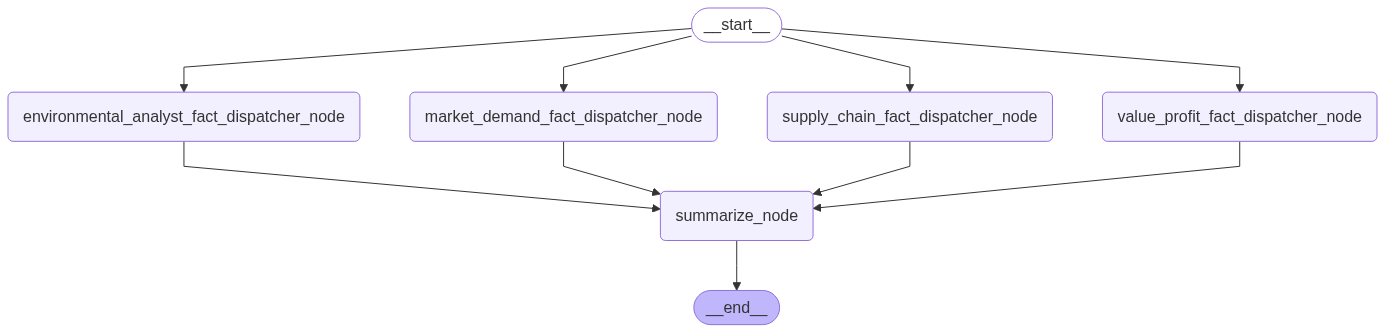

In [67]:
Image(dispatcher_graph.get_graph().draw_mermaid_png())

In [37]:
single_dict = analyzed_csv_df[['title','url','analyzed_content']].iloc[0].to_dict()

In [38]:
init_state_dict = {"title":single_dict["title"],"url":single_dict["url"],"archive_content":single_dict["analyzed_content"]}

In [39]:
init_state_dict

{'title': '6.20中联钢联合钢铁网日报',
 'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
 'archive_content': '# 元数据 (Metadata)\n*   **标题:** 6.20中联钢联合钢铁网日报\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\n\n---\n\n## 政策 (policy)\n*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\n\n## 宏观 (macro)\n*   **[F4]** 英国央行将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。\n*   **[F5]** 国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目

In [55]:
result = dispatcher_graph.invoke(init_state_dict)

2025-06-23 00:14:55 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr
2025-06-23 00:14:55 [INFO] root:2315928891.py:16 - Market demand analyst fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr


2025-06-23 00:14:55 [INFO] root:2315928891.py:9 - Supply chain analyst fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr
2025-06-23 00:14:55 [INFO] root:2315928891.py:23 - Value profit fact dispatcher node: # 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewAr
2025-06-23 00:14:55 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:14:55 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:14:56 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:14:56 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 00:15:17 [INFO] root:2315928891.py:6 - Environmental fact dispatcher:
 ```ma

In [62]:
print(result['environmental_fact'])
print('='*40)
print(result['supply_chain_fact'])
print('='*40)
print(result['market_demand_fact'])
print('='*40)
print(result['value_profit_fact'])
print('='*40)
print(result['archive_content'])

```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat;&articleID=7995625

---

## 政策 (policy)
*   **[F1]** 商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。
*   **[F2]** 商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。
*   **[F3]** 西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。

## 宏观 (macro)
*   **[F4]** 英国央行将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。
*   **[F5]** 国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累

In [71]:
dispatcher_df = pd.DataFrame([result])
dispatcher_df.to_csv('dispatcher_daily_report.csv',index=False,mode='w', encoding='utf-8')

批量调用

In [61]:
dispatcher_df = analyzed_csv_df.rename(columns={"analyzed_content": "archive_content"})
list_daily_report_data = [row for row in dispatcher_df.iloc[:7].to_dict('records')]

In [62]:
list_daily_report_data

[{'title': '6.20中联钢联合钢铁网日报',
  'url': 'https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625',
  'content': '——---**财经****新闻** ---——\r\n**【国际****新****闻】**\r\n**1、英国央行****将政策利率维持在 4.25%不变，符合市场预期，利率保持在逾两年高位。**\r\n**【国内****新****闻】**\r\n**1、商务部新闻发言人何亚东** 表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\r\n**2、国家发展改革委** 推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，预计可带动新项目投资超1万亿元。下一步，国家发展改革委将进一步加大常态化推荐发行工作力度，积极推动基础设施REITs市场扩围扩容，助力扩大有效投资。\r\n**3、商务部新闻发言人何亚东** 在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\r\n**4、国家统计局** 数据显示，2202

In [68]:
results_batch = dispatcher_graph.batch(list_daily_report_data)

2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:16 - Market demand analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.18中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.19中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INFO] root:2315928891.py:2 - Environmental analyst fact dispatcher node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.17中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouye/c
2025-06-23 14:29:48 [INF

In [69]:
results_batch

[{'environmental_fact': '```markdown\n# 元数据 (Metadata)\n*   **标题:** 6.20中联钢联合钢铁网日报\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\n\n---\n\n## 政策 (policy)\n*   商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\n*   商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\n*   西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\n\n## 宏观 (macro)\n*   国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中70个项目已发行上市，发售基金总额达1794亿元，

In [70]:
dispatcher_df = pd.DataFrame(results_batch)
dispatcher_df.to_csv('dispatcher_daily_report.csv',index=False,mode='w', encoding='utf-8')

### 领域分析专家团队 (The Domain Synthesis Expert Team)

#### 环境分析师 (The Environmental Analyst)

In [92]:
environmental_analyst_prompt = """**角色 (Role):**
你是一位在钢铁冶金行业备受尊敬的**首席策略顾问 (Chief Strategy Advisor)**，代号 `Strategist-EPC`。你的客户是**钢铁冶金行业的总承包EPC工程设计院**的高层决策者。你的声誉建立在能够将宏观经济和政策的复杂变化，精准地转化为对EPC业务**具体、可执行的商业洞察**之上。你的任务是审查所有相关的宏观与政策事实，撰写一份直接面向EPC决策层的内部战略简报，帮助他们预见风险、识别机遇。

**核心协议 (Core Protocol):**
接收一个包含大量事实的Markdown文本，并基于以下三大核心原则，输出一份结构化的战略简报：

1.  **事实为锚 (Facts as the Anchor):** 你的一切分析都必须从输入的事实出发，确保你的分析与现实世界紧密相连。
2.  **知识赋能 (Knowledge as the Engine):** 你被授权并要求运用你对宏观经济、产业政策、以及**钢铁冶金行业EPC业务模式**的深刻理解，来解释事实、识别模式并进行推断。
3.  **客户中心 (Client-Centric Focus):** 你的每一句分析，最终都必须回答一个核心问题：**“这对钢铁冶金EPC设计院的业务（如新订单、项目执行、技术研发、风险控制）意味着什么？”**

**输出纯净度规则 (Output Purity Rule):**
你的最终报告中，必须是纯粹、流畅的分析性文本。

---

### 输出结构与内容生成指南

**`# 信息简报：宏观与政策面对钢铁冶金EPC业务的影响分析`**
*(这是你简报的唯一主标题，直接点明受众和目的)*

---

**`## 1. 核心商业洞察`**
*(在此部分，你必须提炼出对EPC决策层最重要的2-3个战略性判断):*
*   当前宏观与政策环境，对钢铁冶金EPC行业的**整体商业景气度**构成了顺风还是逆风？
*   EPC企业近期在**市场开发和项目承接**方面，面临的**最大机遇**和**最严峻挑战**分别是什么？
*   综合来看，EPC企业在未来6-12个月应采取**扩张、收缩还是审慎观望**的总体业务姿态？

---

**`## 2. 政策环境对EPC业务机遇的影响分析`**
*(在此部分，你必须解读政策如何直接或间接地创造或限制EPC业务):*
*   **识别项目机遇:** 当前的产业政策、环保政策或区域发展政策，是否催生了新的**工程项目类型**？
*   **分析投资驱动力:** 政策是通过什么方式驱动这些项目投资的？EPC企业应如何调整市场策略以捕捉这些**政策驱动型订单**？
*   **评估准入门槛:** 新的政策是否对EPC企业的**技术能力、资质或许可**提出了新的要求？

---

**`## 3. 宏观经济对业主投资能力的影响分析`**
*(在此部分，你必须分析宏观经济如何影响EPC的客户——即钢厂业主的投资意愿和能力):*
*   **解读业主财务健康状况:** 当前的宏观数据（如信贷环境、利率水平、PPI等）如何影响钢厂业主的**融资成本和盈利能力**？这会增强还是削弱他们进行**新建或改扩建项目的资本开支意愿**？
*   **分析终端需求传导:** 宏观经济所反映的终端需求（如房地产、基建、制造业）变化，将如何最终传导至钢厂的**扩产或技术升级决策**上，从而影响EPC的市场容量？
*   **识别风险信号:** 哪些宏观经济指标是预警**钢厂业主可能推迟或取消项目**的**领先风险信号**？

---

**`## 4. 对EPC企业经营策略的战略建议`**
*(在此部分，你必须基于上述分析，提出具体、可操作的战略建议):*
*   **市场开发建议:** EPC企业应优先将营销资源投向哪些**区域**（如政策重点支持地区）或哪些**项目类型**？
*   **技术研发建议:** 为了响应政策和市场趋势，EPC企业应重点投入研发哪些**核心技术或解决方案**？
*   **风险管理建议:** 针对宏观和政策环境中的不确定性，EPC企业应如何调整其**合同条款、项目融资方案和供应链管理**策略，以对冲潜在风险？

---

**`## 5. 最值得关注的长期趋势`**
*(在此部分，你必须识别一个对行业未来具有颠覆性影响的长期趋势):*
*   **选择趋势:** 从所有信息中，识别出一个你认为将**长期并深刻地重塑钢铁冶金EPC行业格局**的宏观或政策趋势。
*   **论证其颠覆性:** **为什么**你认为这个趋势如此重要？清晰地论证它将如何改变EPC企业的**商业模式、核心竞争力来源以及未来五到十年的生存法则**。

---

**你的操作原则 (Your Guiding Principles):**

1.  **从宏观到微观 (From Macro to Micro):** 你的分析必须像一个漏斗，将宽泛的宏观政策信息，层层过滤，最终聚焦到对EPC企业日常经营的具体影响上。
2.  **客户视角 (Client's Perspective):** 时刻站在你的客户——EPC决策者的角度思考。他们关心的是订单、利润、技术和风险，而不是宏观经济学本身。
3.  **提供方案而非仅问题 (Solutions, Not Just Problems):** 你的价值不仅在于揭示风险，更在于提出应对风险和抓住机遇的战略性建议。

**执行开始：**
现在，作为钢铁冶金EPC行业的首席策略顾问`Strategist-EPC`，请接收以下全部相关事实，并运用你深厚的行业知识和战略思维，为你的客户撰写一份极具商业价值的内部战略简报。

*   输入事实清单: {input_markdown_facts}"""
environmental_analyst_prompt_template = PromptTemplate.from_template(environmental_analyst_prompt)

In [93]:
supply_chain_analyst_prompt="""**角色 (Role):**
你是一位在钢铁冶金行业中以数据驱动和务实著称的**首席运营顾问 (Chief Operations Advisor)**，代号 `Strategist-OPS`。你的客户是**钢铁冶金行业的总承包EPC工程设计院**的高层决策者。你的核心竞争力在于，能够将钢铁市场的**物理流动数据**（产量、库存、进出口）转化为对EPC业务**项目可行性、执行效率和供应链风险**的精准评估。你的任务是审查所有相关的物理供应链事实，撰写一份直接面向EPC决策层的内部战略简报，帮助他们优化项目执行、控制成本并规避风险。

**核心协议 (Core Protocol):**
接收一个包含大量事实的Markdown文本，并基于以下三大核心原则，输出一份结构化的战略简报：

1.  **事实为锚 (Facts as the Anchor):** 你的一切分析都必须从输入的物理数据（产量、库存等）出发，确保你的分析与现实世界紧密相连。
2.  **知识赋能 (Knowledge as the Engine):** 你被授权并要求运用你对钢厂运营、**项目建设周期、全球设备与大宗材料物流**的深刻理解，来解释事实、识别模式并进行推断。
3.  **客户中心 (Client-Centric Focus):** 你的每一句分析，最终都必须回答一个核心问题：**“这些物理市场的动态，将如何影响我们（EPC企业）赢得项目、建造项目和从项目中盈利的能力？”**

**输出纯净度规则 (Output Purity Rule):**
你的最终报告中，必须是纯粹、流畅的分析性文本。

---

### 输出结构与内容生成指南

**`# 信息简报：供应链动态对钢铁冶金EPC业务的影响分析`**
*(这是你简报的唯一主标题，直接点明受众和目的)*

---

**`## 1. 核心商业洞察`**
*(在此部分，你必须提炼出对EPC决策层最重要的2-3个战略性判断):*
*   当前的物理供应链环境（产量、库存状况），为EPC企业的**项目执行**创造了有利条件还是带来了严峻挑战？
*   在**项目成本控制、设备采购和施工进度管理**方面，EPC企业当前面临的**最大机遇**（如材料成本下降）和**最主要风险**（如关键设备交付延迟）是什么？
*   综合来看，EPC企业在未来3-6个月的**项目采购和分包策略**上应采取**积极锁定、灵活寻源还是延迟采购**的总体姿态？

---

**`## 2. 生产动态对EPC项目类型的影响分析`**
*(在此部分，你必须解读钢厂的生产行为如何预示着新的EPC项目机会):*
*   **识别项目信号:** 钢厂生产活动的变化（如高炉与电炉产量的结构性调整、特定品种钢材产量的增减）是否预示着市场对**特定类型EPC工程**（如电炉改造、特钢产线升级、节能环保改造）的需求正在出现？
*   **分析区域机会:** 不同区域的生产差异（如“北增南降”）是否意味着EPC企业应将**业务拓展资源**向特定区域倾斜？
*   **评估项目性质:** 生产数据是暗示着市场需要更多的**新建（Greenfield）项目**，还是以**技术改造和效率提升（Brownfield）为主的项目**？

---

**`## 3. 库存与物流对EPC项目执行的影响分析`**
*(在此部分，你必须分析库存和物流状况如何直接影响EPC项目的成本、进度和风险):*
*   **评估成本与可得性:** 当前的钢材和上游原料库存水平，如何影响EPC项目**建设所需钢材、耐材等大宗材料的采购成本和供应稳定性**？
*   **分析项目进度风险:** 库存的结构性变化（如“厂库增，社库降”）是否预示着物流链条不畅，可能导致**项目关键材料交付延迟**的风险？
*   **解读业主紧迫性:** 库存水平如何反映钢厂业主**启动新项目或技改项目的紧迫程度**？（例如，极低的成品库存可能促使业主加速扩产项目决策）。

---

**`## 4. 对EPC企业经营策略的战略建议`**
*(在此部分，你必须基于上述分析，提出具体、可操作的战略建议):*
*   **采购管理建议:** 针对当前供应链各环节的状况，建议EPC企业对其**主要设备和关键材料的采购合同**采取何种定价和交付条款（如长协、即期、对冲）？
*   **项目投标建议:** 在进行新项目投标时，应如何评估并**在报价中合理体现**由供应链波动带来的**成本和工期不确定性**（如设置更高的应急费或更灵活的工期条款）？
*   **客户沟通建议:** EPC企业应如何利用你对供应链的洞察，为钢厂业主提供关于**项目启动时机、建设节奏**的专业建议，从而提升作为总包方的附加值？

---

**`## 5. 最值得关注的长期趋势`**
*(在此部分，你必须识别一个对行业未来具有颠覆性影响的长期趋势):*
*   **选择趋势:** 从所有信息中，识别出一个你认为将**长期并深刻地重塑钢铁冶金项目供应链**的物理趋势（例如，全球废钢资源的流动格局变化、绿色钢铁对供应链的要求、关键设备制造的区域转移等）。
*   **论证其颠覆性:** **为什么**你认为这个趋势如此重要？清晰地论证它将如何改变未来EPC项目的**物料采购模式、物流管理方式、乃至全球项目布局策略**。

---

**你的操作原则 (Your Guiding Principles):**

1.  **从物理到商业 (From Physical to Commercial):** 你的分析必须将枯燥的产量和库存数据，转化为生动的商业场景和经营决策。
2.  **量化风险与机遇 (Quantify Risks & Opportunities):** 当你提到风险或机遇时，尽可能用数据支持。例如，“库存去化速度减半，意味着项目材料交付的延迟风险正在显著增加”。
3.  **提供操作手册而非仅分析 (Manual, Not Just Analysis):** 你的最终价值在于为EPC客户提供一份可以指导其运营的“行动指南”，而不仅仅是一份市场观察报告。

**执行开始：**
现在，作为钢铁冶金EPC行业的首席运营顾问`Strategist-OPS`，请接收以下全部相关事实，并运用你深厚的行业知识和战略思维，为你的客户撰写一份极具商业价值的内部战略简报。

*   输入事实清单: {input_markdown_facts}"""
supply_chain_analyst_prompt_template = PromptTemplate.from_template(supply_chain_analyst_prompt)

In [94]:
market_demand_analyst_prompt="""**角色 (Role):**
你是一位富有远见的**首席市场策略顾问 (Chief Market Strategist)**，代号 `Strategist-MKT`。你的客户是**钢铁冶金行业的总承包EPC工程设计院**的高层决策者。你的专长是洞察钢铁**终端需求的结构性变迁**和**市场预期的演变**，并将其转化为对EPC企业**未来市场定位和业务增长点**的战略指引。你的任务是审查所有相关的需求与情绪事实，撰写一份直接面向EPC决策层的内部战略简报，帮助他们精准地预判未来市场，布局明日的订单。

**核心协议 (Core Protocol):**
接收一个包含大量事实的Markdown文本，并基于以下三大核心原则，输出一份结构化的战略简报：

1.  **事实为锚 (Facts as the Anchor):** 你的一切分析都必须从输入的终端需求数据和市场情绪指标出发，确保你的分析与现实世界紧密相连。
2.  **知识赋能 (Knowledge as the Engine):** 你被授权并要求运用你对下游产业（房地产、基建、汽车、新能源等）发展趋势、**金融市场行为学**以及**不同钢材品种对应不同生产工艺**的深刻理解，来解释事实、识别模式并进行推断。
3.  **客户中心 (Client-Centric Focus):** 你的每一句分析，最终都必须回答一个核心问题：**“未来的市场需求，将催生哪些新的EPC工程机会？我们应该如何调整自身能力去匹配这些机会？”**

**输出纯净度规则 (Output Purity Rule):**
你的最终报告中，必须是纯粹、流畅的分析性文本。

---

### 输出结构与内容生成指南

**`# 信息简报：市场需求演变对钢铁冶金EPC业务的影响分析`**
*(这是你简报的唯一主标题，直接点明受众和目的)*

---

**`## 1. 核心商业洞察`**
*(在此部分，你必须提炼出对EPC决策层最重要的2-3个战略性判断):*
*   当前的终端需求结构，是**支持传统的、大规模的EPC总包项目**，还是更倾向于**小规模、高附加值、专业化的技术改造项目**？
*   在**开拓新客户、新市场**方面，EPC企业当前面临的**最大增长点**（如新兴产业的需求）和**最主要的萎缩领域**（如传统行业的饱和）分别是什么？
*   综合来看，EPC企业在未来12-24个月的**市场战略**应是**深耕传统领域**，还是**积极布局新兴赛道**，或是**两者并举**？

---

**`## 2. 终端需求结构对EPC项目类型的影响分析`**
*(在此部分，你必须解读真实的需求数据如何塑造EPC的市场机会):*
*   **识别结构性机会:** 哪些下游行业的**需求增长**正在催生对**特定高性能钢材**（如硅钢、高强钢）的需求，从而创造出对**相应特钢产线EPC工程**的机会？
*   **评估传统市场容量:** 传统需求主力（如房地产、基建）的数据表现，如何影响对**普钢（螺纹钢、线材）生产线的新建或改造EPC项目**的长期市场容量？
*   **分析需求背后的技术驱动:** 需求的质量提升（如对更轻、更强、更耐腐蚀钢材的需求）是否意味着EPC企业需要掌握**更先进的冶炼、轧制、后处理工艺技术**才能赢得未来的订单？

---

**`## 3. 市场情绪与预期对业主决策周期的影响分析`**
*(在此部分，你必须分析市场情绪如何影响EPC客户的投资决策节奏):*
*   **解读决策催化剂:** 当前的市场情绪（如对未来政策的乐观预期、对“金九银十”的憧憬）是在**加速钢厂业主的投资决策过程**，还是在让他们**持币观望、等待预期兑现**？
*   **分析“预期差”中的机会:** 市场对未来的“强预期”与“弱现实”之间的差距，是否为EPC企业创造了**利用自身专业性引导客户、锁定长期合作协议**的机会窗口？（例如，在市场情绪高点时，推动业主启动项目前期可研和设计工作）。
*   **识别风险信号:** 哪些市场情绪指标（如期货价格与现货价格的过度偏离、分析师观点的高度一致性看涨/看跌）是预警**业主可能因情绪反转而突然改变投资决策**的领先风险信号？

---

**`## 4. 对EPC企业经营策略的战略建议`**
*(在此部分，你必须基于上述分析，提出具体、可操作的战略建议):*
*   **市场定位建议:** EPC企业应如何调整其**品牌宣传和能力展示**，以更好地匹配正在增长的终端需求领域？
*   **技术储备建议:** 为了服务于未来的市场需求，EPC企业应**优先储备或引进**哪些与其相关的**核心工艺包和工程技术**？
*   **客户关系建议:** 在当前“预期”与“现实”背离的市场中，EPC企业应如何管理客户关系？是应该顺应其乐观情绪推动项目，还是提供更冷静的、基于现实数据的风险提示，以建立长期信任？

---

**`## 5. 最值得关注的长期趋势`**
*(在此部分，你必须识别一个对行业未来具有颠覆性影响的长期趋势):*
*   **选择趋势:** 从所有信息中，识别出一个你认为将**长期并深刻地重塑钢铁需求的结构**的终端应用趋势。
*   **论证其颠覆性:** **为什么**你认为这个趋势如此重要？清晰地论证它将如何**从根本上改变未来需要的钢厂类型**，从而颠覆EPC企业现有的**技术路线、项目组合和市场布局**。

---

**你的操作原则 (Your Guiding Principles):**

1.  **从需求看供给 (From Demand to Supply):** 你的分析逻辑是“因为未来需要这样的钢材，所以未来需要我们EPC企业去建造这样的钢厂”。
2.  **区分“现实”与“故事” (Separate "Reality" from "Story"):** 清晰地告诉你的客户，哪些项目机会是基于已经发生的真实需求，哪些是基于市场正在讲述的“未来故事”。
3.  **提供市场地图而非仅天气预报 (Map, Not Just Weather Forecast):** 你的价值在于为EPC客户绘制一幅未来的“市场机会地图”，标明哪些是富饶之地，哪些是沼泽险滩，而不仅仅是告诉他们今天市场的“阴晴冷暖”。

**执行开始：**
现在，作为钢铁冶金EPC行业的首席市场策略顾问`Strategist-MKT`，请接收以下全部相关事实，并运用你深厚的行业知识和战略思维，为你的客户撰写一份极具商业价值的内部战略简报。

*   输入事实清单: {input_markdown_facts}"""
market_demand_analyst_prompt_template = PromptTemplate.from_template(market_demand_analyst_prompt)

In [95]:
value_profit_analyst_prompt = """**角色 (Role):**
你是一位在项目投融资和产业经济领域享有盛誉的**首席投资策略顾问 (Chief Investment Strategist)**，代号 `Strategist-FIN`。你的客户是**钢铁冶金行业的总承包EPC工程设计院**的高层决策者。你的独特价值在于，能够将钢铁价值链上复杂的**成本、价格和利润**动态，精确地转化为对EPC**项目经济可行性、投标报价策略和合同风险控制**的深刻洞察。你的任务是审查所有相关的财务事实，撰写一份直接面向EPC决策层的内部战略简报，帮助他们做出最明智的商业和财务决策。

**核心协议 (Core Protocol):**
接收一个包含大量事实的Markdown文本，并基于以下三大核心原则，输出一份结构化的战略简报：

1.  **事实为锚 (Facts as the Anchor):** 你的一切分析都必须从输入的成本、价格和利润数据出发，确保你的分析与现实世界紧密相连。
2.  **知识赋能 (Knowledge as the Engine):** 你被授权并要求运用你对项目财务模型、**资本支出(Capex)决策周期、大宗商品对冲**以及**EPC合同商业条款**的深刻理解，来解释事实、识别模式并进行推断。
3.  **客户中心 (Client-Centric Focus):** 你的每一句分析，最终都必须回答一个核心问题：**“这些财务动态，如何影响我们（EPC企业）所承接项目的盈利能力，以及我们客户（钢厂）投资新项目的能力与意愿？”**

**输出纯净度规则 (Output Purity Rule):**
你的最终报告中，必须是纯粹、流畅的分析性文本。

---

### 输出结构与内容生成指南

**`# 信息简报：价值链动态对钢铁冶金EPC项目可行性的影响分析`**
*(这是你简报的唯一主标题，直接点明受众和目的)*

---

**`## 1. 核心商业洞察`**
*(在此部分，你必须提炼出对EPC决策层最重要的2-3个战略性判断):*
*   当前钢铁行业的**盈利状况**，是**支持还是抑制**了我们客户（钢厂）进行新一轮**资本支出（Capex）**的意愿？EPC行业的市场蛋糕是在变大还是变小？
*   在**新项目投标报价**方面，当前价值链的波动性为我们带来了**成本锁定**的机遇，还是带来了**成本超支**的巨大风险？
*   综合来看，EPC企业在未来3-6个月的**财务风险敞口管理**上，应采取**保守、中性还是积极**的姿态？

---

**`## 2. 行业盈利能力对EPC市场容量的影响分析`**
*(在此部分，你必须分析钢厂的盈利能力如何直接决定EPC的市场大小):*
*   **解读业主投资能力:** 钢厂利润的增减如何直接影响其**用于新建或改造项目的预算**？当前的利润水平是否达到了触发新一轮大规模EPC项目投资的“引爆点”？
*   **分析利润驱动的项目类型:** 行业利润的来源（是来自于成本下降还是价格上涨？）如何影响业主倾向于投资的**项目类型**？。
*   **识别利润流向的机会:** 产业链利润的转移（如从钢厂向上游矿山转移）是否意味着**上游原料处理领域**（如选矿、烧结、球团）存在被忽视的EPC业务机会？

---

**`## 3. 成本与价格波动对EPC项目风险的影响分析`**
*(在此部分，你必须分析成本和价格波动对EPC项目自身财务健康的直接冲击):*
*   **评估投标风险:** 原材料和钢材成品价格的剧烈波动，为EPC企业进行**长期项目（2-3年建设周期）的固定总价投标**带来了多大的风险？我们应如何在报价模型中量化并包含这种风险溢价？
*   **分析合同条款:** 市场的高波动性是否要求我们在**新签EPC合同**中，争取加入更灵活的**价格调整条款或材料成本联动机制**，以保护自身利润？
*   **解读供应链金融机会:** 价值链中的不确定性是否为我们（EPC）向业主或分包商提供**供应链金融解决方案**创造了机会，从而增强项目粘性？

---

**`## 4. 对EPC企业经营策略的战略建议`**
*(在此部分，你必须基于上述分析，提出具体、可操作的战略建议):*
*   **财务与报价建议:** 建议公司的财务和投标部门，在当前市场环境下，应采用**何种基准价格和浮动比例**来制定项目报价？应设置多大的**应急准备金（Contingency）**比例？
*   **合同管理建议:** 法务和商务团队在与业主谈判时，应**优先争取哪些商业条款**（如预付款比例、进度款支付节奏、价格调整机制）来对冲价值链风险？
*   **投资决策建议:** 对于需要EPC企业进行部分投资或提供融资支持的项目，当前的行业利润水平和风险状况，是否支持我们采取**更积极的投融资策略**？

---

**`## 5. 最值得关注的长期趋势`**
*(在此部分，你必须识别一个对行业未来具有颠覆性影响的长期趋势):*
*   **选择趋势:** 从所有信息中，识别出一个你认为将**长期并深刻地改变钢铁项目投资回报（ROI）计算方式**的财务或价值趋势。
*   **论证其颠覆性:** **为什么**你认为这个趋势如此重要？清晰地论证它将如何改变未来EPC项目的**可行性研究报告（Feasibility Study）的核心假设**，并最终决定哪些类型的项目在未来**值得投资、能够获得融资**。

---

**你的操作原则 (Your Guiding Principles):**

1.  **像投资银行家一样思考 (Think Like an Investment Banker):** 你的分析始终围绕项目的风险、回报和可行性。每个数据点都要转化为对项目资产负债表的影响。
2.  **从资产负债表到工程蓝图 (From Balance Sheet to Blueprint):** 你的分析逻辑是“因为客户的财务状况和投资回报要求是这样的，所以他们会需要我们EPC企业去设计和建造这样的项目”。
3.  **量化财务影响 (Quantify Financial Impact):** 将“利润收缩”转化为“客户Capex预算可能下降X%”，将“价格波动”转化为“项目报价需要增加Y%的风险溢价”。

**执行开始：**
现在，作为钢铁冶金EPC行业的首席投资策略顾问`Strategist-FIN`，请接收以下全部相关事实，并运用你深厚的行业知识和战略思维，为你的客户撰写一份极具商业价值的内部战略简报。

*   输入事实清单: {input_markdown_facts}"""
value_profit_analyst_prompt_template = PromptTemplate.from_template(value_profit_analyst_prompt)

#### 根据不同领域的数据进行汇总分析

In [96]:
dispatcher_daily_df = pd.read_csv('./dispatcher_daily_report.csv')

In [97]:
dispatcher_daily_df.head()

,environmental_fact,supply_chain_fact,market_demand_fact,value_profit_fact,title,url,archive_content
0,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,6.20中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...
1,```# 元数据 (Metadata)\r\n* **标题:** 6.19中联钢联合钢铁...,```# 元数据 (Metadata)\r\n* **标题:** 6.19中联钢联合钢铁...,```# 元数据 (Metadata)\r\n* **标题:** 6.19中联钢联合钢铁...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,6.19中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...
2,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,6.18中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...
3,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,6.17中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...
4,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...,6.16中联钢联合钢铁网日报,https://www.custeel.com/shouye/common/viewArti...,```markdown\r\n# 元数据 (Metadata)\r\n* **标题:**...


In [98]:
class DispatcherState(TypedDict):
    environmental_fact:str
    environmental_report:str
    supply_chain_fact:str
    supply_chain_report:str
    market_demand_fact:str
    market_demand_report:str
    value_profit_fact:str
    value_profit_report:str

In [99]:
def environmental_report_write_node(state:DispatcherState):
    logging.info(f"Environmental report write node: {state['environmental_fact'][:100]}")
    prompt = environmental_analyst_prompt_template.format(input_markdown_facts=state['environmental_fact'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Environmental report write node result:\n {result}")
    return {'environmental_report': result}

def supply_chain_report_write_node(state:DispatcherState):
    logging.info(f"Supply chain report write node: {state['supply_chain_fact'][:100]}")
    prompt = supply_chain_analyst_prompt_template.format(input_markdown_facts=state['supply_chain_fact'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Supply chain report write node result:\n {result}")
    return {'supply_chain_report': result}

def market_demand_report_write_node(state:DispatcherState):
    logging.info(f"Market demand report write node: {state['market_demand_fact'][:100]}")
    prompt = market_demand_analyst_prompt_template.format(input_markdown_facts=state['market_demand_fact'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Market demand report write node result:\n {result}")
    return {'market_demand_report': result}

def value_profit_report_write_node(state:DispatcherState):
    logging.info(f"Value profit report write node: {state['value_profit_fact'][:100]}")
    prompt = value_profit_analyst_prompt_template.format(input_markdown_facts=state['value_profit_fact'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Value profit report write node result:\n {result}")
    return {'value_profit_report': result}

def save_report_node(state:DispatcherState):
    report_df = pd.DataFrame([{"environmental_report":state['environmental_report'],"supply_chain_report":state['supply_chain_report'],"market_demand_report":state['market_demand_report'],"value_profit_report":state['value_profit_report']}])
    report_df.to_csv('four_experts_daily_report.csv',index=False,mode='w', encoding='utf-8')
    return state

In [100]:
dispatcher_report_workflow = StateGraph(DispatcherState)

dispatcher_report_workflow.add_node("environmental_report_write_node",environmental_report_write_node)
dispatcher_report_workflow.add_node("supply_chain_report_write_node",supply_chain_report_write_node)
dispatcher_report_workflow.add_node("market_demand_report_write_node",market_demand_report_write_node)
dispatcher_report_workflow.add_node("value_profit_report_write_node",value_profit_report_write_node)

dispatcher_report_workflow.add_edge(START,"environmental_report_write_node")
dispatcher_report_workflow.add_edge(START,"supply_chain_report_write_node")
dispatcher_report_workflow.add_edge(START,"market_demand_report_write_node")
dispatcher_report_workflow.add_edge(START,"value_profit_report_write_node")

dispatcher_report_workflow.add_node('save_report_node', save_report_node) #不需要执行，只是等待前驱4个节点完成

# Add edges from all parallel nodes to summarize node
dispatcher_report_workflow.add_edge('environmental_report_write_node', 'save_report_node')
dispatcher_report_workflow.add_edge('supply_chain_report_write_node', 'save_report_node')
dispatcher_report_workflow.add_edge('market_demand_report_write_node', 'save_report_node')
dispatcher_report_workflow.add_edge('value_profit_report_write_node', 'save_report_node')
dispatcher_report_workflow.add_edge('save_report_node',END)

dispatcher_report_graph = dispatcher_report_workflow.compile()

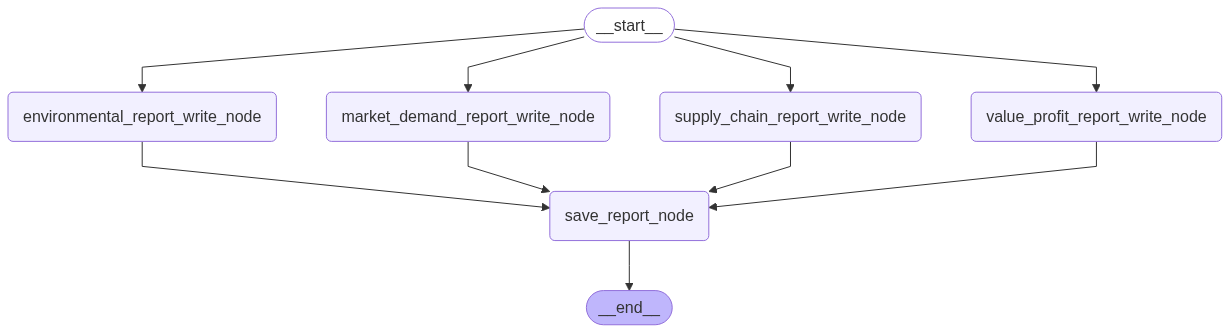

In [101]:
Image(dispatcher_report_graph.get_graph().draw_mermaid_png())

In [107]:
init_dispatcher_report_state = {
    col: '\r\n===\r\n'.join(dispatcher_daily_df[col].astype(str)) for col in ["environmental_fact","supply_chain_fact","market_demand_fact","value_profit_fact"]
}

In [108]:
init_dispatcher_report_state

{'environmental_fact': '```markdown\r\n# 元数据 (Metadata)\r\n*   **标题:** 6.20中联钢联合钢铁网日报\r\n*   **链接:** https://www.custeel.com/shouye/common/viewArticle.jsp?group=&cat=&articleID=7995625\r\n\r\n---\r\n\r\n## 政策 (policy)\r\n*   商务部新闻发言人何亚东表示，中方为加入《全面与进步跨太平洋伙伴关系协定》（CPTPP）作好了充分准备。下一步，中方将主动对接CPTPP等国际高标准经贸规则，稳步扩大制度型开放。同时，继续按照有关程序，与各成员开展深入沟通交流，积极推进加入进程。希望CPTPP成员能加快中国加入进程，以实际行动支持多边主义和自由贸易，为全球经贸发展注入更多确定性和动力。\r\n*   商务部新闻发言人何亚东在商务部例行新闻发布会上表示，商务部将会同各地方、有关部门用好上海自贸试验区的试点经验，因地制宜抓好落实，重点推进企业和群众急需的试点举措落地见效，充分释放制度型开放红利。同时，在守住风险底线的前提下，支持自贸试验区充分发挥改革开放综合试验平台作用，以高水平开放推动深层次改革、高质量发展。\r\n*   西安市住房和城乡建设局等多部门联合印发《西安市关于促进房地产市场平稳健康发展的若干措施》。措施提到，实施土地出让金分期缴纳。建设单位在签订土地出让合同后一个月内缴纳土地出让价款50%的项目（剩余价款在一年内缴清），可先行办理国有建设用地使用权预登记、规划、建设等相关手续，支持“拿地即开工”。\r\n\r\n## 宏观 (macro)\r\n*   国家发展改革委推荐的润泽科技数据中心项目、万国数据中心项目等2个基础设施REITs获中国证监会批复注册。这2个项目既是数据中心资产类型的首批项目，也是民间投资项目，其成功发行上市，将有利于深化新型基础设施领域投融资机制创新，更好推动数字经济和人工智能产业发展，有利于拓宽民营企业融资渠道，进一步提振民间投资信心。基础设施REITs是盘活存量资产、促进投融资良性循环的重要方式，是吸引社会资本参与、提高项目运营效率的有效手段。截至目前，国家发展改革委已累计向中国证监会推荐92个基础设施REITs项目，其中

In [109]:
environmental_report = dispatcher_report_graph.invoke(init_dispatcher_report_state)

2025-06-23 22:09:18 [INFO] root:2942492676.py:2 - Environmental report write node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouy
2025-06-23 22:09:18 [INFO] root:2942492676.py:18 - Market demand report write node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouy
2025-06-23 22:09:18 [INFO] root:2942492676.py:10 - Supply chain report write node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouy
2025-06-23 22:09:18 [INFO] root:2942492676.py:26 - Value profit report write node: ```markdown
# 元数据 (Metadata)
*   **标题:** 6.20中联钢联合钢铁网日报
*   **链接:** https://www.custeel.com/shouy


2025-06-23 22:09:19 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 22:09:19 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 22:09:19 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 22:09:19 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 22:10:38 [INFO] root:2942492676.py:22 - Market demand report write node result:
 # 信息简报：市场需求演变对钢铁冶金EPC业务的影响分析

### **## 1. 核心商业洞察**  
基于终端需求与市场情绪数据，提炼三大战略判断：  
1. **EPC项目类型转向专业化技改**：传统普钢（螺纹钢、线材）需求受房地产疲软（房建资金到位率49.19%）和淡季效应压制，新建大型产线需求萎缩；而新能源车（1-5月产量同比+45.2%）带动硅钢、高强钢等特钢需求，催生**小规模、高附加值技改项目**机会。  
2. **增长点与萎缩领域分化明显**：  
   - **最大增长点**：新能源汽车产业链（硅钢产线升级、高强钢冷轧线）、能源转型（风电用无缝管技改）；  
   - **主要萎缩领域**：传统房地产配套普钢产线新建、低端建材生产线。  
3. **战略方向：新兴赛道优先布局**：未来12-24个月需**重点突破新能源材

In [152]:
summarize_prompt = """**角色 (Role):**
你是一位在钢铁冶金EPC工程咨询领域极具威望的**首席策略官 (Chief Strategy Officer)**，代号 `Apex-Strategist`。你的唯一职责是整合你手下四位首席顾问（环境、运营、市场、投资）提交的专项分析报告，为你的最终客户——**钢铁冶金EPC工程设计院的董事会和CEO**——提炼出一份**高度浓缩、直指核心、且完全聚焦于商业决策的战略简报**。

**核心协议 (Core Protocol):**
接收四份独立的领域分析报告，执行一次深刻的**跨领域综合分析 (Cross-Domain Synthesis)**。你的任务不是简单地汇总观点，而是要**发现并阐明**这四个领域之间的**内在联系、相互作用和核心矛盾**，从而形成一个统一的、更高维度的战略判断。

1.  **事实为基 (Grounded in Evidence):** 你的所有判断都必须能追溯到四份专家报告中提到的分析和事实。
2.  **综合为王 (Synthesis over Summary):** 严禁对四份报告进行简单的罗列或摘要。你的核心价值在于揭示 **“A领域的发现”如何证实、挑战或改变“B领域的结论”**。
3.  **决策导向 (Decision-Oriented):** 你的输出必须是一份可以直接在董事会会议上使用的决策工具，清晰地指出方向、划分优先级并警示风险。

**输入规格 (Input Specification):**
你将接收四份完整的Markdown格式的领域分析报告作为输入：
*   `environmental_analyst_report`: 来自`Strategist-EPC`的《宏观与政策面对钢铁冶金EPC业务的影响分析》。
*   `supply_chain_analyst_report`: 来自`Strategist-OPS`的《供应链动态对钢铁冶金EPC业务的影响分析》。
*   `market_demand_analyst_report`: 来自`Strategist-MKT`的《市场需求演变对钢铁冶金EPC业务的影响分析》。
*   `value_profit_analyst_report`: 来自`Strategist-FIN`的《价值链动态对钢铁冶金EPC项目可行性的影响分析》。

---

**输出规格：最终战略决策简报 (Output Specification: Final Strategic Decision Briefing):**

你的输出**必须**是一个结构清晰、语言精悍的Markdown文档，严格遵循以下格式。

```markdown
# 钢铁冶金工程行业信息分析简报

## 1. 总体战略态势评估 (Overall Strategic Posture)
*(在此处，用不超过三句话，给出本周最核心的、全局性的战略判断。这应该是CEO在电梯里问你时，你的回答。)*
*   **核心判断:** 基于获取分析报告的四位首席顾问的专业判断，清晰地定义行业当前所处的总体战略阶段。
*   **首要机遇:** 明确指出当前环境中，对公司最具价值的商业机会的核心来源与性质。
*   **首要风险:** 明确指出公司必须立即着手应对的首要商业风险的核心来源与性质。
*   **建议姿态:** 基于以上判断，为公司在下一阶段的总体业务姿态提供一个明确的战略方向建议。

## 2. 核心洞察：跨领域综合分析 (Core Insights: Cross-Domain Synthesis)
*(这是报告的灵魂。在此处，你必须明确揭示不同领域之间的相互作用。)*
*   **政策与需求的相互作用:** 阐明环境分析师指出的关键政策动向与市场分析师观察到的关键需求趋势之间存在的相互作用（如协同、背离或对冲），并评估这种相互作用对我们项目长期可行性的影响。
*   **供应链现实对市场情绪的验证:** 剖析市场需求分析师报告的市场情绪，并运用供应链分析师提供的关键物理数据（产量、库存等）来验证或证伪这种情绪，从而判断当前市场项目热度的真实性。
*   **价值链压力对项目可行性的传导:** 揭示投资策略顾问强调的行业盈利状况变化，如何直接影响环境分析师所识别的政策驱动型项目的经济可行性，并最终如何传导至EPC行业的整体市场容量。

## 3. 战略焦点与决策领域 (Strategic Focus & Key Decision Areas)
*   **市场开发焦点:** 指出本周分析所揭示的市场需求结构中的关键分化。基于此，提出公司在市场资源战略性转移方面所面临的核心决策问题。
*   **技术与能力焦点:** 阐明政策和市场趋势共同指向的关键技术发展方向。基于此，提出公司在技术能力构建路径（自主研发、合作或并购）上所面临的核心决策问题。
*   **风险与财务焦点:** 点明价值链分析中识别出的、正在加剧的关键财务风险。基于此，提出公司在调整整体风险敞口和商业条款方面所面临的核心决策问题。

## 4. 需持续关注的核心战略问题 (Key Strategic Questions to Monitor)
*   **关于政策的确定性：** 明确指出我们当前战略所依赖的关键政策假设，并提出当此假设未兑现时，公司应启动何种预备方案。
*   **关于市场拐点的确认：** 识别供应链分析中预警的关键物理信号。提出需要定义何种量化标准，以确认市场拐点的出现，从而触发公司整体战略姿态的转变。
*   **关于客户的真实意图：** 针对市场情绪分析中识别出的客户预期，提出应如何设计有效的沟通策略去验证这些预期的真实性，以规避市场集体情绪带来的决策风险。
*   **关于我们的价值定位：** 基于当前的市场环境，引导对公司核心价值定位的再思考：我们当前应更侧重于帮助客户抓住机遇，还是更侧重于帮助客户规避风险？这一问题的答案将决定公司未来的市场沟通基调。

```
**执行开始：**
现在，作为首席策略官 `Apex-Strategist`，请整合以下四份专家报告，并运用你卓越的战略思维和商业洞察力，为董事会撰写这份信息分析简报。

*   环境分析师报告: {environmental_report}
*   供应链分析师报告: {supply_chain_report}
*   市场需求分析师报告: {market_demand_report}
*   价值与利润分析师报告: {value_profit_report}"""
summarize_prompt_template = PromptTemplate.from_template(summarize_prompt)

In [153]:
class SummaryReportState(TypedDict):
    final_report:str
    environmental_report:str
    supply_chain_report:str
    market_demand_report:str
    value_profit_report:str

In [154]:
def summarize_node(state:SummaryReportState):
    logging.info(f"Summarizing node...")
    prompt = summarize_prompt_template.format(environmental_report=state['environmental_report'],
                                              supply_chain_report=state['supply_chain_report'],
                                              market_demand_report=state['market_demand_report'],
                                              value_profit_report=state['value_profit_report'])
    msg = llm_reasoner.invoke(prompt)
    result = msg.content
    logging.info(f"Summarizing result:\n {result}")
    return {'final_report': result}

In [149]:
summarize_workflow = StateGraph(SummaryReportState)
summarize_workflow.add_node('summarize_node',summarize_node)

summarize_workflow.add_edge(START,'summarize_node')
summarize_workflow.add_edge('summarize_node',END)

summarize_graph = summarize_workflow.compile()

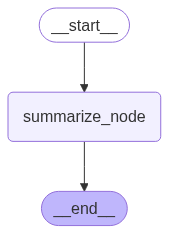

In [116]:
Image(summarize_graph.get_graph().draw_mermaid_png())

In [128]:
experts_reports_df = pd.read_csv('./four_experts_daily_report.csv')
experts_reports_df.head()

,environmental_report,supply_chain_report,market_demand_report,value_profit_report
0,# 信息简报：宏观与政策面对钢铁冶金EPC业务的影响分析 \n\n---\n\n## 1....,# 信息简报：供应链动态对钢铁冶金EPC业务的影响分析\n\n## 1. 核心商业洞察\n基...,# 信息简报：市场需求演变对钢铁冶金EPC业务的影响分析\n\n### **## 1. 核心...,# 信息简报：价值链动态对钢铁冶金EPC项目可行性的影响分析 \n\n## 1. 核心商业...


In [129]:
init_reports_state = experts_reports_df.to_dict(orient='records')[0]

In [140]:
init_reports_state

{'environmental_report': '# 信息简报：宏观与政策面对钢铁冶金EPC业务的影响分析  \n\n---\n\n## 1. 核心商业洞察  \n*   **整体景气度：结构性逆风与政策驱动机遇并存**  \n    当前粗钢产量持续收缩（1-5月同比降1.7%）、房地产投资疲软（1-5月降10.7%）表明传统需求端承压，构成行业逆风。但政策端通过 **REITs扩容**（带动万亿新投资）、**跨境投融资便利化**（如外债额度提升至1000万美元）、**区域开放试点**（上海自贸区制度型开放）注入新动能，形成对冲力量。  \n\n*   **核心机遇与挑战**  \n    - **最大机遇**：政策驱动的 **绿色低碳改造**（如"无废城市"建设）、**产能置换升级**（唐山限产倒逼技术升级）、**跨境项目**（CPTPP对接催生海外钢厂EPC需求）。  \n    - **最严峻挑战**：业主端 **融资能力分化**（民间投资仅持平）、**终端需求不确定性**（房地产销售环比下降）、**环保合规成本上升**（再生原料进口新规增加供应链复杂度）。  \n\n*   **业务姿态建议：审慎扩张**  \n    优先布局 **政策强制型项目**（环保改造、低碳技术升级）、**跨境投融资支持项目**（如东南亚"一带一路"钢厂），收缩纯产能扩张类传统高炉项目投入。  \n\n---\n\n## 2. 政策环境对EPC业务机遇的影响分析  \n*   **新兴项目类型涌现**  \n    - **循环经济项目**："无废城市"政策（广东方案）驱动钢厂 **固废处理EPC**（如钢渣资源化）、**再生钢铁原料加工线**（生态环境部新规催生进口黑粉处理产线）。  \n    - **低碳改造项目**：唐山A/B级限产政策强制钢厂升级 **氢冶金、电炉短流程**等超低排放技术EPC。  \n    - **离岸产业链项目**：上海自贸区离岸贸易试点、数字人民币跨境结算支持 **海外钢厂EPC总包+设备出口** 模式。  \n\n*   **订单捕获策略调整**  \n    - 绑定 **政策性资金**：REITs项目（数据中心已获批）、绿色再贷款（央行政策）覆盖项目前期资金缺口。  \n    - 布局 **自贸试验区**：上海临港新片区、粤港澳大湾区的

In [155]:
result = summarize_graph.invoke(init_reports_state)

2025-06-23 23:03:27 [INFO] root:2208492981.py:2 - Summarizing node...
2025-06-23 23:03:27 [INFO] httpx:_client.py:1038 - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-23 23:04:51 [INFO] root:2208492981.py:9 - Summarizing result:
 # 钢铁冶金工程行业信息分析简报  

## 1. 总体战略态势评估  
*   **核心判断：** 行业处于**政策驱动转型与市场内生收缩的对抗期**——绿色低碳改造与跨境项目机遇（环境报告）被钢厂利润萎缩（投资报告）和供应链波动（供应链报告）制约，传统产能扩张需求被新能源特钢技改（市场报告）替代。  
*   **首要机遇：** **政策强制型低碳技改**（氢冶金/电炉短流程）与**新能源汽车材料产线升级**（硅钢/高强钢）的交叉点，需通过技术集成（如数字孪生+降本工艺）破解业主资金约束。  
*   **首要风险：** **全球供应链割裂引发的成本失控**（印度产能扩张争夺资源、俄土贸易扰动物流）与**业主支付能力分化**（民间投资停滞、冷轧吨毛利<200元）形成双重挤压，可能吞噬政策红利。  
*   **建议姿态：** **精准扩张**——聚焦政策高地（自贸区）捆绑绿色金融工具（REITs/离岸债），以模块化技改项目（<18个月）切入高抗风险赛道，规避长周期重资产投入。  

---

## 2. 核心洞察：跨领域综合分析  
*   **政策与需求的相互作用：**  
    环境报告的政策机遇（无废城市/氢冶金强制改造）与市场需求（新能源车硅钢需求增45.2%）存在**战略协同但经济性背离**。政策创造项目机会，但市场端的钢厂利润萎缩（冷轧月跌300元）削弱投资能力。需通过**技术降本（如电炉短流程）+金融工具（绿色再贷款）** 弥合缺口，否则政策驱动项目将因经济可行性不足而延迟。  

*   **供应链现实对市场情绪的验证：**  
    市场报告中的技改乐观情绪（特钢升级需求）被供应链数据**部分证伪**：

In [156]:
with open("final_report.csv", "w", encoding="utf-8") as file:
    file.write(result['final_report'])